In [2]:
import shots_data_retriever
from shots_data_retriever import ShotsDataRetriever
import importlib
import warnings
import pandas as pd

# Filter dtype warnings. Column 10 can contain str, int, and float types 
# which spams a warning in the output
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
importlib.reload(shots_data_retriever)

shotsDataRetriever = ShotsDataRetriever()
df = shotsDataRetriever.get_all_shots()

Retrieving shots data: 100%|██████████| 40/40 [02:33<00:00,  3.84s/it]


In [107]:
print(all_shots.iloc[:,10].dtype)

object


In [78]:
regular_season_shots = all_shots[all_shots['season'] == 'season']
playoff_season_shots = all_shots[all_shots['season'] == 'playoffs']

for year in shotsDataRetriever.SEASONS:
    curr_year_shots = all_shots[all_shots['year'] == year]
    regular_season_shots = curr_year_shots[curr_year_shots['season'] == 'season']
    playoff_season_shots = curr_year_shots[curr_year_shots['season'] == 'playoffs']

    avg_shot_rate_playoffs = len(playoff_season_shots) / playoff_season_shots['game_id'].nunique()
    avg_shot_rate_regular = len(regular_season_shots) / regular_season_shots['game_id'].nunique()

    print(f"year: {year}")
    print(f"{curr_year_shots['team_id'].nunique()} teams: {curr_year_shots['team_id'].unique()}")
    print(f"Regular avg shot rate: {avg_shot_rate_regular}")
    print(f"Playoffs avg shot rate: {avg_shot_rate_playoffs}")
    for team_id in curr_year_shots['team_id'].unique():
        curr_team_shots = curr_year_shots[curr_year_shots['team_id'] == team_id]
        print(f"team {team_id} played {curr_team_shots['game_id'].nunique()} games in {year}")


year: 2016
28 teams: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 28 29 30]
Regular avg shot rate: 57.210268948655255
Playoffs avg shot rate: 62.48275862068966
team 1 played 82 games in 2016
team 2 played 82 games in 2016
team 3 played 94 games in 2016
team 4 played 82 games in 2016
team 5 played 107 games in 2016
team 6 played 88 games in 2016
team 7 played 82 games in 2016
team 8 played 88 games in 2016
team 9 played 101 games in 2016
team 10 played 88 games in 2016
team 12 played 82 games in 2016
team 13 played 82 games in 2016
team 14 played 82 games in 2016
team 15 played 95 games in 2016
team 16 played 86 games in 2016
team 17 played 82 games in 2016
team 18 played 104 games in 2016
team 19 played 93 games in 2016
team 20 played 86 games in 2016
team 21 played 82 games in 2016
team 22 played 95 games in 2016
team 23 played 82 games in 2016
team 24 played 99 games in 2016
team 25 played 82 games in 2016
team 26 played 82 games in 2016
team 28 played

In [88]:
games_per_team_per_season = all_shots.groupby(['team_id', 'year', 'season'])['game_id'].nunique().reset_index(name="total games")
print(games_per_team_per_season)
#games_per_team_season.to_csv("tempdata.csv")

     team_id  year    season  total games
0          1  2016    season           82
1          1  2017  playoffs            5
2          1  2017    season           82
3          1  2018    season           82
4          1  2019    season           69
..       ...   ...       ...          ...
334       30  2021  playoffs            6
335       30  2021    season           82
336       30  2022  playoffs            6
337       30  2022    season           82
338       30  2023    season           82

[339 rows x 4 columns]


In [64]:
# Average shot rate
single_game_time = 1 # in hours, assumption from google doc
total_games = df['game_id'].nunique()
total_game_time = single_game_time * total_games
shot_location_league = df.groupby(['x_coord', 'y_coord']).size().reset_index(name='shot_count')
shot_location_league['shot_rate'] = shot_location_league['shot_count'] / total_game_time
# shot_location_league.to_csv('test_league.csv', index=False)

In [5]:
# Shot rate by team
total_game_time_per_team = df.groupby('team_id')['game_id'].nunique().reset_index(name='time_played')
shot_location_group = df.groupby(['team_id', 'x_coord', 'y_coord']).size().reset_index(name='shot_count')
shot_location_group = pd.merge(shot_location_group, total_game_time_per_team, on='team_id', how='left')
shot_location_group['shot_rate'] = shot_location_group['shot_count'] / shot_location_group['time_played']
# shot_location_group.to_csv('test_team.csv', index=False)

In [76]:
# Difference from league average
full_df = pd.DataFrame()
d = pd.DataFrame()
d['team_id'] = shot_location_group['team_id']
d['x_coord'] = shot_location_group['x_coord']
d['y_coord'] = shot_location_group['y_coord']

d = d.groupby('team_id')
for g in d:
    team_id = g[1]['team_id'].iloc[0]
    x_coord = g[1]['x_coord'].iloc[0]
    y_coord = g[1]['y_coord'].iloc[0]
    merge_df = pd.merge(
        shot_location_group,
        shot_location_league[['x_coord', 'y_coord', 'shot_rate']].rename(columns={'shot_rate': 'shot_rate_league'}),
        on=['x_coord', 'y_coord'],
        how='left'
    )
    merge_df = merge_df.drop('shot_rate_league_y', axis=1)
    full_df = pd.concat([full_df, shot_location_group[shot_location_group['team_id'] == team_id]])
    full_df = pd.merge(full_df, merge_df, how='left')
    full_df = full_df.drop('shot_rate_league_x', axis=1)
    full_df = full_df.drop('shot_count', axis=1)
    full_df = full_df.drop('time_played', axis=1)
print(full_df)
full_df.to_csv('full_df.csv', index=False)

        team_id  x_coord  y_coord  shot_rate  shot_rate_league
0             1      0.0    -26.0   0.001577          0.000293
1             1      0.0    -18.0   0.001577          0.000391
2             1      0.0      2.0   0.001577          0.000781
3             1      0.0      3.0   0.001577          0.000976
4             1      0.0     11.0   0.001577          0.000098
...         ...      ...      ...        ...               ...
145439       30     97.0     22.0   0.001548          0.000488
145440       30     97.0     23.0   0.001548          0.000195
145441       30     98.0    -20.0   0.001548          0.000195
145442       30     99.0     -0.0   0.001548          0.000098
145443       30     99.0     11.0   0.001548          0.000293

[145444 rows x 5 columns]


In [ ]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.colors import make_colorscale
import os
from PIL import Image
from scipy.ndimage import gaussian_filter

In [7]:
# The input df is a df of all shots that we want to graph. Each row corresponds to a shot.
# We want to create the map for a given year, so we also take a year as an input.
# We also want to be able to select a team, so team_id as an input as well.
# Output is a 101 x 85 2d array mapping each shot.

def create_shot_map(df, year, team_id):
    # First, we want to filter only the year of the shots we want:
    selected_year = df['game_id'].astype(str).str[:4] == str(year)
    filtered_shots = df[selected_year]

    # Second, select the team we want:
    selected_team = filtered_shots['team_id'] == team_id
    filtered_shots = filtered_shots[selected_team]

    # Remove na values
    filtered_shots = filtered_shots.dropna(subset=['x_coord', 'y_coord'])

    # Now that we've filtered all the shots we want, we create a 101 x 85 array with all shot frequencies
    x_indices = filtered_shots['x_coord'].astype(int)
    y_indices = (filtered_shots['y_coord'] + 42).astype(int) # shift it up to put it in the range of 0-85
    
    shot_map = np.zeros([101,85], dtype=int)
    np.add.at(shot_map, (x_indices, y_indices), 1)
    
    return shot_map

shot_map = create_shot_map(all_shots, 2020, 15)

Drawing plot: 100%|██████████| 101/101 [00:06<00:00, 16.04it/s]


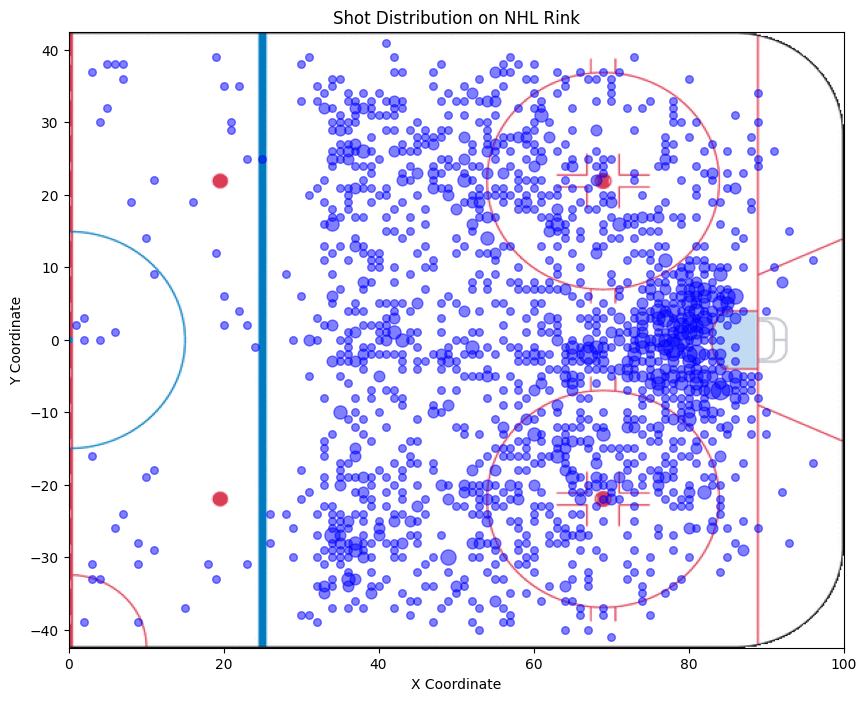

In [6]:
# Now that we have a shot map, we want to plot it

def plot_shot_map_matplotlib(shot_map):
    rink_image = mpimg.imread("../../figures/nhl_rink.png")

    plt.figure(figsize=(10, 8))
    plt.imshow(rink_image, extent=[-100, 100, -42.5, 42.5], aspect='auto')

    for i in tqdm(range(shot_map.shape[0]), desc="Drawing plot"):
        for j in range(shot_map.shape[1]):
            if shot_map[i, j] > 0:
                plt.scatter(i, j - 42, s=shot_map[i, j] * 30, color='blue', alpha=0.5)  # Adjust y-coordinates

    plt.xlim(0, 100)
    plt.ylim(-42.5, 42.5)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Shot Distribution on NHL Rink')

    plt.show()

plot_shot_map_matplotlib(shot_map)

In [8]:
def plot_shot_map_plotly(shot_map):
    rink_image_path = os.path.abspath("../../figures/nhl_rink.png")

    fig = go.Figure()

    fig.add_layout_image(
        dict(
            source=Image.open("../../figures/nhl_rink.png"),
            x=-100,
            y=42.5,
            xref="x",
            yref="y",
            sizex=200,  # Total width of the rink in feet
            sizey=85,   # Total height of the rink in feet
            opacity=1,
            sizing="stretch",
            xanchor="left",
            yanchor="top",
            layer="below"  # To ensure the image is below the scatter points
        )
    )

    for i in tqdm(range(shot_map.shape[0]), desc="Processing shots"):  # Iterate over x-coordinates (0 to 100)
        for j in range(shot_map.shape[1]):  # Iterate over y-coordinates (-42.5 to 42.5)
            if shot_map[i, j] > 0:  # Only plot if there's at least one shot
                fig.add_trace(go.Scatter(
                    x=[i],  # x coordinate
                    y=[j - 42],  # y coordinate adjusted for proper positioning
                    mode='markers',
                    marker=dict(size=shot_map[i, j] * 5, opacity=0.5, color='blue'),  # Size based on the shot count
                    showlegend=False
                )) 

    fig.update_layout(
        xaxis=dict(title='X Coordinate (feet)', range=[0, 100]),  # x-axis from 0 to 100
        yaxis=dict(title='Y Coordinate (feet)', range=[-42.5, 42.5]),  # y-axis from -42.5 to 42.5
        title='Shot Distribution on NHL Rink',
        showlegend=False,
        height=425,  # Set the height of the figure
        width=500,    )
    fig.show()

plot_shot_map_plotly(shot_map)

Processing shots: 100%|██████████| 101/101 [00:01<00:00, 51.22it/s]


In [46]:

def plot_shot_heatmap_plotly(shot_map):
    x = np.linspace(0, 100, shot_map.shape[0])  # x coordinates
    y = np.linspace(-42, 42, shot_map.shape[1])  # y coordinates
    
    xedges = np.linspace(0, 100, shot_map.shape[0] + 1)  # Adding 1 to include the last edge
    yedges = np.linspace(-42, 42, shot_map.shape[1] + 1)  # Adding 1 to include the last edge

    # Create a 2D histogram (heatmap) of the shot counts
    heatmap, _, _ = np.histogram2d(
        np.repeat(x, shot_map.shape[1]),  # x positions
        np.tile(y, shot_map.shape[0]),    # y positions
        weights=shot_map.flatten(),        # Use shot counts as weights
        bins=[xedges, yedges]
    )

    heatmap = gaussian_filter(heatmap, sigma=3)  # Adjust sigma for smoothing
    #heatmap = np.where(heatmap < 0.001, np.nan, heatmap)

    fig = go.Figure()

    fig.update_layout(
        plot_bgcolor='white',  # Background color of the plot area
        paper_bgcolor='white'  # Background color of the entire figure
    )

    fig.add_layout_image(
        dict(
            source=Image.open("../../figures/nhl_rink.png"),
            x=-100,
            y=42.5,
            xref="x",
            yref="y",
            sizex=200,  # Total width of the rink in feet
            sizey=85,   # Total height of the rink in feet
            opacity=1,
            sizing="stretch",
            xanchor="left",
            yanchor="top",
            layer="below"  # To ensure the image is below the scatter points
        )
    )

    custom_colorscale = [[0, 'rgba(0,0,255,0)'], [0.001, 'rgba(0,0,255,0.05)'], [1, 'rgba(255,0,0,1)']]

    fig.add_trace(go.Heatmap(
        z=heatmap.T,  # Transpose heatmap to match x and y coordinates
        x=xedges[:-1],  # x-axis edges
        y=yedges[:-1],  # y-axis edges
        colorscale=custom_colorscale,  # Choose a color scale
        colorbar=dict(title='Shot Density'),  # Add color bar title
        zmin=0,  # Minimum value for color scale
        zmax=np.max(heatmap),  # Maximum value for color scale
        # opacity=0.5,
        hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Shot Density: %{z:.2f}<extra></extra>',
    ))

    fig.update_layout(
        xaxis=dict(title='X Coordinate (feet)', range=[0, 100]),  # x-axis from 0 to 100
        yaxis=dict(title='Y Coordinate (feet)', range=[-42.5, 42.5]),  # y-axis from -42.5 to 42.5
        title='Shot Distribution on NHL Rink',
        showlegend=False,
        height=425,  # Set the height of the figure
        width=500,    )
    fig.show()

plot_shot_heatmap_plotly(shot_map)